# Useful Packages for Working with Data

Julia has both a large number of useful, well written libraries and many incomplete poorly maintained proofs of concept.

A major advantage of Julia libraries is that, because Julia itself is sufficiently fast, there is less need to mix in low level languages like C and Fortran.

As a result, most Julia libraries are written exclusively in Julia.

Not only does this make the libraries more portable, it makes them much easier to dive into, read, learn from and modify.

In this lecture we introduce a few of the Julia libraries that we’ve found particularly useful for quantitative work in economics.

## Automatic Differentiation with `ForwardDiff`

Julia's generic programming facilities have enabled the development of useful packages for algebra and calculus. One of the most useful for our purposes is `ForwardDiff` which implements a form of **Automatic Differentiation**. In essence, `ForwardDiff` can calculate gradients/Hessians/Jacobians **analytically** by taking advantage of Julia's type system and using [dual numbers](https://en.wikipedia.org/wiki/Dual_number). Here's an example of `ForwardDiff` in action.

In [ ]:
using ForwardDiff
h(x) = sin(x[1]) + x[1] * x[2] + sinh(x[1] * x[2]) # multivariate.
x = [1.4 2.2]
@show ForwardDiff.gradient(h, x) # use AD, at point x

#Or, can use complicated functions of many variables
f(x) = sum(sin, x) + prod(tan, x) * sum(sqrt, x)
g = (x) -> ForwardDiff.gradient(f, x); # g() is now the gradient
g(rand(5)) # gradient at a random point
# ForwardDiff.hessian(f,x') # or the hessian

ForwardDiff.gradient(h, x) = [26.35476496103098 16.663053156992287]


5-element Vector{Float64}:
 0.8582784341517928
 0.7691969109010919
 1.2153974149918836
 1.1374865237940777
 1.0044096728886325

We can even auto-differentiate complicated functions with embedded iterations.

In [27]:
function squareroot(x) #pretending we don't know sqrt()
    z = copy(x) # Initial starting point for Newton’s method
    while abs(z * z - x) > 1e-13
        z = z - (z * z - x) / (2z)
    end
    return z
end
squareroot(2.0)

1.4142135623730951

In [28]:
using ForwardDiff
dsqrt(x) = ForwardDiff.derivative(squareroot, x)
dsqrt(2.0)

0.35355339059327373

## Interpolation
In economics we often wish to interpolate discrete data (i.e., build continuous functions that join discrete sequences of points).

The package we usually turn to for this purpose is [Interpolations.jl](https://github.com/JuliaMath/Interpolations.jl).

There are a variety of options, but we will only demonstrate the convenient notations. Later, David will show you some more advanced techniques for creating your own interpolations.

### Univariate with a Regular Grid

Let’s start with the univariate case.

We begin by creating some data points, using a sine function

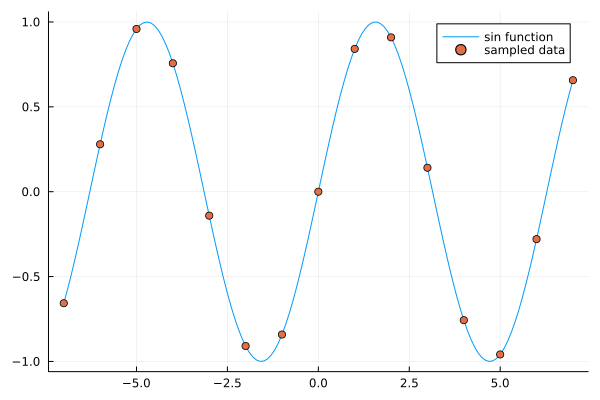

In [2]:
using Interpolations
using Plots

x = -7:7 # x points, coase grid
y = sin.(x) # corresponding y points

xf = -7:0.1:7        # fine grid
plot(xf, sin.(xf), label = "sin function")
scatter!(x, y, label = "sampled data", markersize = 4)

To implement linear and cubic spline interpolation:

li(0.3) = 0.25244129544236954


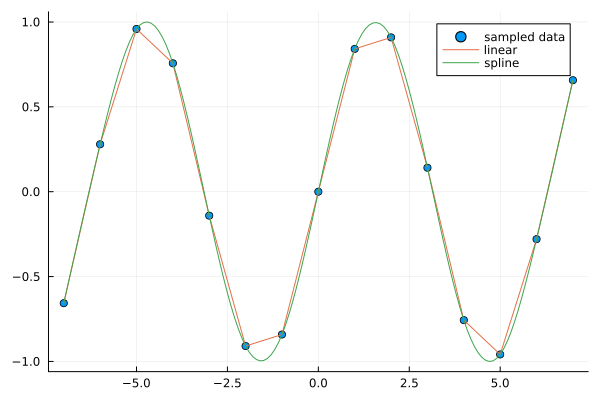

In [3]:
li = LinearInterpolation(x, y)
li_spline = CubicSplineInterpolation(x, y)

@show li(0.3) # evaluate at a single point

scatter(x, y, label = "sampled data", markersize = 4)
plot!(xf, li.(xf), label = "linear")
plot!(xf, li_spline.(xf), label = "spline")

### Univariate with irregular grid
In the above, the `LinearInterpolation` function uses a specialized function for regular grids since `x` is a `Range` type.

For an arbitrary, irregular grid:

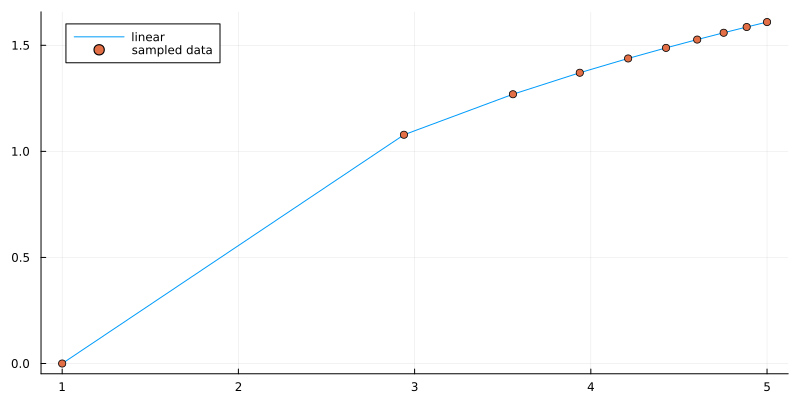

In [4]:
x = log.(range(1, exp(4), length = 10)) .+ 1  # uneven grid
y = log.(x) # corresponding y points

interp = LinearInterpolation(x, y)

xf = log.(range(1, exp(4), length = 100)) .+ 1 # finer grid

plot(xf, interp.(xf), label = "linear")
scatter!(x, y, label = "sampled data", markersize = 4, size = (800, 400))

At this point, `Interpolations.jl` does not have support for cubic splines with irregular grids, but there are plenty of other packages that do (e.g. [Dierckx.jl](https://github.com/kbarbary/Dierckx.jl) and [GridInterpolations.jl](https://github.com/sisl/GridInterpolations.jl)).

### Multivariate Interpolation

Interpolating a regular multivariate function uses the same function

In [6]:
f(x, y) = log(x + y)
xs = 1:0.2:5
ys = 2:0.1:5
A = [f(x, y) for x in xs, y in ys]

# linear interpolation
interp_linear = LinearInterpolation((xs, ys), A)
@show interp_linear(3, 2) # exactly log(3 + 2)
@show interp_linear(3.1, 2.1) # approximately log(3.1 + 2.1)

# cubic spline interpolation
interp_cubic = CubicSplineInterpolation((xs, ys), A)
@show interp_cubic(3, 2) # exactly log(3 + 2)
@show interp_cubic(3.1, 2.1) # approximately log(3.1 + 2.1);;

interp_linear(3, 2) = 1.6094379124341003
interp_linear(3.1, 2.1) = 1.6484736801441782
interp_cubic(3, 2) = 1.6094379124341
interp_cubic(3.1, 2.1) = 1.6486586594237707


1.6486586594237707

## ProgressMeter.jl

For long-running operations, you can use the [ProgressMeter.jl](https://github.com/timholy/ProgressMeter.jl) package which makes your own user experience a bit better.

To use the package, you simply put a macro in front of for loops, etc.

From the documentation:

In [9]:
using ProgressMeter

@showprogress 1 "Computing..." for i in 1:50
    sleep(0.1) # some computation....
end

Computing... 100%|███████████████████████████████████████| Time: 0:00:05


## `DataFrames`

While Julia is not an ideal language for pure cookie-cutter statistical analysis (R or Stata tend to be better), it has many useful packages to provide those tools as part of a more general solution.

A critical package is [DataFrames.jl](https://github.com/JuliaStats/DataFrames.jl), which provides a two-dimensional `DataFrame` array type which stores heterogeneous data. This is analogous to a `data.frame` in R, a `DataFrame` in Pandas (Python) or, more loosely, a spreadsheet in Excel.

### Constructing and Accessing a DataFrame

There are a few different ways to create a DataFrame.

The first is to set up columns and construct a dataframe by assigning names.

In [15]:
using DataFrames, RDatasets  # RDatasets provides good standard data examples from R

# note use of missing
commodities = ["crude", "gas", "gold", "silver"]
last_price = [4.2, 11.3, 12.1, missing]
df = DataFrame(commod = commodities, price = last_price)

Row,commod,price
,String,Float64?
1,crude,4.2
2,gas,11.3
3,gold,12.1
4,silver,missing


Columns of the `DataFrame` can be accessed by name using `df.col`, as below

In [16]:
df.price

4-element Vector{Union{Missing, Float64}}:
  4.2
 11.3
 12.1
   missing

Note that the type of this array has values `Union{Missing, Float64}` since it was created with a `missing` value.

In [17]:
df.commod

4-element Vector{String}:
 "crude"
 "gas"
 "gold"
 "silver"

The `DataFrames.jl` package provides a number of methods for acting on `DataFrame`’s, such as `describe`.

In [18]:
DataFrames.describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,commod,,crude,,silver,0,String
2,price,9.2,4.2,11.3,12.1,1,"Union{Missing, Float64}"


While often data will be generated all at once, or read from a file, you can add to a `DataFrame` by providing the variables through a call to `push!()`.

In [19]:
nt = (commod = "nickel", price = 5.1)
push!(df, nt)

Row,commod,price
,String,Float64?
1,crude,4.2
2,gas,11.3
3,gold,12.1
4,silver,missing
5,nickel,5.1


Named tuples can also be used to construct a `DataFrame`, and have it properly deduce all types.

In [20]:
nt = (t = 1, col1 = 3.0)
df2 = DataFrame([nt])
push!(df2, (t = 2, col1 = 4.0))

Row,t,col1
,Int64,Float64
1,1,3.0
2,2,4.0


In order to modify a column, access the mutating version by the symbol `df[!, :col]`.

In [21]:
df[!, :price]

5-element Vector{Union{Missing, Float64}}:
  4.2
 11.3
 12.1
   missing
  5.1

Which allows modifications, like other mutating `!` functions in julia.

In [22]:
df[!, :price] *= 2.0  # double prices

5-element Vector{Union{Missing, Float64}}:
  8.4
 22.6
 24.2
   missing
 10.2

As discussed in the next section, note that the [fundamental types](https://julia.quantecon.org/../getting_started_julia/fundamental_types.html#missing), is propagated, i.e. `missing * 2 === missing`.

### Working with Missing

The semantics of `missing` are that mathematical operations will not silently ignore it.

In order to allow `missing` in a column, you can create/load the `DataFrame`
from a source with `missing`’s, or call `allowmissing!` on a column.

In [23]:
allowmissing!(df2, :col1) # necessary to add in a for col1
push!(df2, (t = 3, col1 = missing))
push!(df2, (t = 4, col1 = 5.1))

Row,t,col1
,Int64,Float64?
1,1,3.0
2,2,4.0
3,3,missing
4,4,5.1


In this example, we can see the propagation of `missing` to caller functions, as well as a way to efficiently calculate with non-missing data.

In [28]:
using Statistics
@show mean(df2.col1)
@show mean(skipmissing(df2.col1))

mean(df2.col1) = missing
mean(skipmissing(df2.col1)) = 4.033333333333333


4.033333333333333

There is also a way to replace `missing` values easily:

In [29]:
df2.col1 .= coalesce.(df2.col1, 0.0) # replace all missing with 0.0

4-element Vector{Float64}:
 3.0
 4.0
 0.0
 5.1

### Manipulating and Transforming DataFrames

One way to do an additional calculation with a `DataFrame` is to tuse the `@transform` macro from `DataFramesMeta.jl`.

In [32]:
using DataFramesMeta
f(x) = x^2
df2 = @transform(df2, :col2=f.(:col1))

Row,t,col1,col2
,Int64,Float64,Float64
1,1,3.0,9.0
2,2,4.0,16.0
3,3,0.0,0.0
4,4,5.1,26.01


### Categorical Data

For data that is [categorical](https://juliadata.github.io/DataFrames.jl/stable/man/categorical/)

In [33]:
using CategoricalArrays
id = [1, 2, 3, 4]
y = ["old", "young", "young", "old"]
y = CategoricalArray(y)
df = DataFrame(id = id, y = y)

Row,id,y
,Int64,Cat…
1,1,old
2,2,young
3,3,young
4,4,old


In [34]:
levels(df.y)

2-element Vector{String}:
 "old"
 "young"

### Querying

The `DataFrame` (and similar types that fulfill a standard generic interface) can fit into a variety of packages.

One set of them is the [QueryVerse](https://github.com/queryverse).

**Note:** The QueryVerse, in the same spirit as R’s tidyverse, makes heavy use of the pipeline syntax `|>`.

In [35]:
x = 3.0
f(x) = x^2
g(x) = log(x)

@show g(f(x))
@show x |> f |> g; # pipes nest function calls

g(f(x)) = 2.1972245773362196
(x |> f) |> g = 2.1972245773362196


To give an example directly from the source of the LINQ inspired [Query.jl](http://www.queryverse.org/Query.jl/stable/)

In [38]:
using Query

df = DataFrame(name = ["John", "Sally", "Kirk"],
               age = [23.0, 42.0, 59.0],
               children = [3, 5, 2])

x = @from i in df begin
    @where i.age > 50
    @select {i.name, i.children}
    @collect DataFrame
end

Row,name,children
,String,Int64
1,Kirk,2


## Getting data into Julia with `CSV.jl`

Often we will want to do analysis with data that we've downloaded or generated or otherwise processed outside of Julia. There are many ways to do this depending on the format of the data that you have. An easy way for CSV files is to use the [CSV.jl](https://csv.juliadata.org/stable/) package. We're going to use an example from the author of the `DataFrames` package, Bogumił Kamiński: a dataset of chess puzzles.

First, we need to download and extract the dataset. You can do so [here](https://database.lichess.org/lichess_db_puzzle.csv.bz2). Suppose the extracted file is named `new_puzzles.csv`. You can use the `pwd()` command to see where to put it.

In [2]:
pwd()

"C:\\Users\\keato\\.julia\\environments\\v1.11"

Now, assuming that you've put the file in that directory, you can read it in directly to a DataFrame. I'm using optional arguments here to tell it how the data is laid out.

In [12]:
using CSV
using DataFrames
puzzles = CSV.read("new_puzzles.csv", DataFrame; delim=',', header=["PuzzleId", "FEN", "Moves", "Rating", "RatingDeviation",
                            "Popularity", "NbPlays", "Themes", "GameUrl", "OpeningTag", "OpeningVariation"])

┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 1. Filling remaining columns with `missing`
└ @ CSV C:\Users\keato\.julia\packages\CSV\XLcqT\src\file.jl:592
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 1. Filling remaining columns with `missing`
└ @ CSV C:\Users\keato\.julia\packages\CSV\XLcqT\src\file.jl:592
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 2. Filling remaining columns with `missing`
└ @ CSV C:\Users\keato\.julia\packages\CSV\XLcqT\src\file.jl:592
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 2. Filling remaining columns with `missing`
└ @ CSV C:\Users\keato\.julia\packages\CSV\XLcqT\src\file.jl:592
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 4. Filling remaining columns with `missing`
└ @ CSV C:\Users\keato\.julia\packages\CSV\XLcqT\src\file.jl:592
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 5. Fi

Row,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTag,OpeningVariation
,String7,String,String,Int64,Int64,Int64,Int64,String,String,String?,String?
1,00008,r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - - 0 24,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,1736,78,95,3012,crushing hangingPiece long middlegame,https://lichess.org/787zsVup/black#48,missing,missing
2,0000D,5rk1/1p3ppp/pq3b2/8/8/1P1Q1N2/P4PPP/3R2K1 w - - 2 27,d3d6 f8d8 d6d8 f6d8,1513,74,96,16164,advantage endgame short,https://lichess.org/F8M8OS71#53,missing,missing
3,0009B,r2qr1k1/b1p2ppp/pp4n1/P1P1p3/4P1n1/B2P2Pb/3NBP1P/RN1QR1K1 b - - 1 16,b6c5 e2g4 h3g4 d1g4,1130,75,86,518,advantage middlegame short,https://lichess.org/4MWQCxQ6/black#32,Kings_Pawn_Game,Kings_Pawn_Game_Leonardis_Variation
4,000Vc,8/8/4k1p1/2KpP2p/5PP1/8/8/8 w - - 0 53,g4h5 g6h5 f4f5 e6e5 f5f6 e5f6,1495,155,100,14,crushing endgame long pawnEndgame,https://lichess.org/l6AejDMO#105,missing,missing
5,000Zo,4r3/1k6/pp3r2/1b2P2p/3R1p2/P1R2P2/1P4PP/6K1 w - - 0 35,e5f6 e8e1 g1f2 e1f1,1652,149,100,23,endgame mate mateIn2 short,https://lichess.org/n8Ff742v#69,missing,missing
6,000aY,r4rk1/pp3ppp/2n1b3/q1pp2B1/8/P1Q2NP1/1PP1PP1P/2KR3R w - - 0 15,g5e7 a5c3 b2c3 c6e7,1436,76,86,489,advantage master middlegame short,https://lichess.org/iihZGl6t#29,Benoni_Defense,Benoni_Defense_Benoni-Indian_Defense
7,000hf,r1bqk2r/pp1nbNp1/2p1p2p/8/2BP4/1PN3P1/P3QP1P/3R1RK1 b kq - 0 19,e8f7 e2e6 f7f8 e6f7,1574,76,88,456,mate mateIn2 middlegame short,https://lichess.org/71ygsFeE/black#38,Horwitz_Defense,Horwitz_Defense_Other_variations
8,000mr,5r1k/5rp1/p7/1b2B2p/1P1P1Pq1/2R1Q3/P3p1P1/2R3K1 w - - 0 41,e3g3 f7f4 e5f4 f8f4,1478,279,100,10,crushing middlegame short,https://lichess.org/8sVpuwso#81,missing,missing
9,000rO,3R4/8/K7/pB2b3/1p6/1P2k3/3p4/8 w - - 4 58,a6a5 e5c7 a5b4 c7d8,1039,80,85,61,crushing endgame fork short,https://lichess.org/tzeeBEc2#115,missing,missing


This is big and messy! Let's look at a few summary statistics!

In [13]:
show(describe(puzzles); truncate=14)

11×7 DataFrame
 Row │ variable         mean     min              median  max              nmi ⋯
     │ Symbol           Union…   Any              Union…  Any              Int ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ PuzzleId                  00008                    zzzhg                ⋯
   2 │ FEN                       1B1K4/2P5/4k3/…          rrqb2k1/3n2p1/…
   3 │ Moves                     a1a2 a3a2 b2a2…          h8h7 h6h7 g7h7…
   4 │ Rating           1553.26  545              1513.0  3024
   5 │ RatingDeviation  104.934  49               79.0    500                  ⋯
   6 │ Popularity       83.8078  -100             90.0    200
   7 │ NbPlays          1101.28  0                216.0   310341
   8 │ Themes                    advancedPawn a…          opening
   9 │ GameUrl                   https://liches…          https://liches…      ⋯
  10 │ OpeningTag                Alekhine_Defen…          Zukertort_Open…   23
  11 │ OpeningVa

OK, maybe we want to visualize the data in more detail than that. Histograms work well!

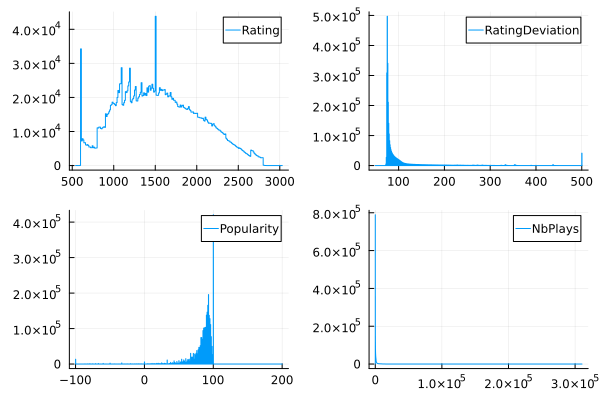

In [14]:
using Plots
plot(histogram(puzzles.Rating; label="Rating"),
histogram(puzzles.RatingDeviation; label="RatingDeviation"),
histogram(puzzles.Popularity; label="Popularity"),
histogram(puzzles.NbPlays; label="NbPlays"))

### Brief Exercise

Rewrite the above code using a comprehension.

## A data cleaning example

Often we get some data and we want to do some checks to make sure that the data means what we think it means, and fix any errors or problems with the data that are not relevant to our research question.

This can be done in Julia just as it could be done in R or Stata or any other package.

Today, we're going to verify the `mateInX` tags that are in this file. Let's take a slice of the data to show you what I mean.

In [18]:
puzzles[1:5, [:Moves, :Themes]]

Row,Moves,Themes
,String,String
1,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,crushing hangingPiece long middlegame
2,d3d6 f8d8 d6d8 f6d8,advantage endgame short
3,b6c5 e2g4 h3g4 d1g4,advantage middlegame short
4,g4h5 g6h5 f4f5 e6e5 f5f6 e5f6,crushing endgame long pawnEndgame
5,e5f6 e8e1 g1f2 e1f1,endgame mate mateIn2 short


The tags are correct if:
- there is no duplicate tagging
- the number of moves in the puzzle matches the tag.

There are many ways to accomplish this. We will do it by transforming our columns into a more convenient form using the `ByRow` functionality of `DataFrames`. 

First, note that within the `Moves` column, the moves are separated by spaces. We can use the `split()` function to split a String into an array of individual 'words' and then the `length()` function to get the number of words in that array. Julia understands the ∘ operator and will compose the functions for us.

Second, we can use the `contains()` function on the `Themes` column along with a comprehension to generate a series of `Bool` columns.

Before we do any of that, however, let's create a new DataFrame that is just a subset of the data that we can then modify to our heart's content.

In [19]:
df = select(puzzles, [:Moves, :Themes])

Row,Moves,Themes
,String,String
1,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,crushing hangingPiece long middlegame
2,d3d6 f8d8 d6d8 f6d8,advantage endgame short
3,b6c5 e2g4 h3g4 d1g4,advantage middlegame short
4,g4h5 g6h5 f4f5 e6e5 f5f6 e5f6,crushing endgame long pawnEndgame
5,e5f6 e8e1 g1f2 e1f1,endgame mate mateIn2 short
6,g5e7 a5c3 b2c3 c6e7,advantage master middlegame short
7,e8f7 e2e6 f7f8 e6f7,mate mateIn2 middlegame short
8,e3g3 f7f4 e5f4 f8f4,crushing middlegame short
9,a6a5 e5c7 a5b4 c7d8,crushing endgame fork short


Now let's alter those columns.

In [21]:
select!(df,
               "Moves" => ByRow(length∘split) => "nmoves",
               ["Themes" => ByRow(contains("mateIn$i")) => "mateIn$i" for i in 1:5])

Row,nmoves,mateIn1,mateIn2,mateIn3,mateIn4,mateIn5
,Int64,Bool,Bool,Bool,Bool,Bool
1,6,false,false,false,false,false
2,4,false,false,false,false,false
3,4,false,false,false,false,false
4,6,false,false,false,false,false
5,4,false,true,false,false,false
6,4,false,false,false,false,false
7,4,false,true,false,false,false
8,4,false,false,false,false,false
9,4,false,false,false,false,false


Now we see that some of the rows are not tagged as `mateInX`. Let us filter them out, to have only tagged rows left (again, we do the operation in-place):

In [ ]:
filter!(row -> any(row[Not("nmoves")]), df) # this condition looks tricky! Why does this work?

Row,nmoves,mateIn1,mateIn2,mateIn3,mateIn4,mateIn5
,Int64,Bool,Bool,Bool,Bool,Bool
1,4,false,true,false,false,false
2,4,false,true,false,false,false
3,4,false,true,false,false,false
4,2,true,false,false,false,false
5,4,false,true,false,false,false
6,4,false,true,false,false,false
7,2,true,false,false,false,false
8,2,true,false,false,false,false
9,4,false,true,false,false,false


Now we can use the `combine()` function to see how the tags work.

In [23]:
combine(groupby(df, "nmoves"), Not("nmoves") .=> sum)

Row,nmoves,mateIn1_sum,mateIn2_sum,mateIn3_sum,mateIn4_sum,mateIn5_sum
,Int64,Int64,Int64,Int64,Int64,Int64
1,2,233733,0,0,0,0
2,4,0,350806,0,0,0
3,6,0,0,86750,0,0
4,8,0,0,0,12484,0
5,10,0,0,0,0,2121
6,12,0,0,0,0,457
7,14,0,0,0,0,163
8,16,0,0,0,0,35
9,18,0,0,0,0,9


The table reads as follows:

- There are no duplicates in tags.
- Tags `mateInX` for X in 1 to 4 range are correct. The `mateIn5` tag actually means a situation where there are five or more moves.

So the verdict is that tagging is correct, but we need to know the interpretation of `mateIn5` column as it is actually five or more moves. We could rename the column to e.g. `mateIn5+` to reflect that or add a metadata to our df table where we would store this information (I leave this to you as an exercise).

## Exercises

1. In the `Random` module the `randexp` function is defined that samples numbers from exponential distribution with scale 1. Draw two 100,000 element samples from this distribution store them in `x` and `y` vectors. Plot histograms of maximum of pairs of sampled values and sum of `x` plus one-half `y`
1. Create a dataframe `df` and store the vectors `x` and `y`, as well as the maximum of the two and `x + y/2` Compute the summary statistics of this data frame using `describe()`